In [2]:
import numpy as np
import pandas as pd
import sklearn
import scipy
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import classification_report, accuracy_score
from sklearn.ensemble import IsolationForest
from sklearn.neighbors import LocalOutlierFactor
from sklearn.svm import OneClassSVM
from sklearn.preprocessing import StandardScaler
from pylab import rcParams
rcParams['figure.figsize'] = 14, 8    #Set the default size of plots to 14x8 inches for better readability
RANDOM_SEED = 42                      #Setting a random seed to ensure reproducibility of results
LABELS = ["Normal", "Fraud"]

In [3]:
file_path = "Dataset/credit_card_data.csv"
data = pd.read_csv(file_path)

In [4]:
data.head()                           #Displaying the first five rows of the dataset to check its structure

,Time,V1,V2,V3,V4,V5,V6,V7,V8,V9,...,V21,V22,V23,V24,V25,V26,V27,V28,Amount,Class
0,0.0,-1.359807,-0.072781,2.536347,1.378155,-0.338321,0.462388,0.239599,0.098698,0.363787,...,-0.018307,0.277838,-0.110474,0.066928,0.128539,-0.189115,0.133558,-0.021053,149.62,0
1,0.0,1.191857,0.266151,0.166480,0.448154,0.060018,-0.082361,-0.078803,0.085102,-0.255425,...,-0.225775,-0.638672,0.101288,-0.339846,0.167170,0.125895,-0.008983,0.014724,2.69,0
2,1.0,-1.358354,-1.340163,1.773209,0.379780,-0.503198,1.800499,0.791461,0.247676,-1.514654,...,0.247998,0.771679,0.909412,-0.689281,-0.327642,-0.139097,-0.055353,-0.059752,378.66,0
3,1.0,-0.966272,-0.185226,1.792993,-0.863291,-0.010309,1.247203,0.237609,0.377436,-1.387024,...,-0.108300,0.005274,-0.190321,-1.175575,0.647376,-0.221929,0.062723,0.061458,123.50,0
4,2.0,-1.158233,0.877737,1.548718,0.403034,-0.407193,0.095921,0.592941,-0.270533,0.817739,...,-0.009431,0.798278,-0.137458,0.141267,-0.206010,0.502292,0.219422,0.215153,69.99,0


In [5]:
data.info()                            #Concise summary of the DataFrame, to see non-nulls and data types (checking potential issues)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 284807 entries, 0 to 284806
Data columns (total 31 columns):
 #   Column  Non-Null Count   Dtype  
---  ------  --------------   -----  
 0   Time    284807 non-null  float64
 1   V1      284807 non-null  float64
 2   V2      284807 non-null  float64
 3   V3      284807 non-null  float64
 4   V4      284807 non-null  float64
 5   V5      284807 non-null  float64
 6   V6      284807 non-null  float64
 7   V7      284807 non-null  float64
 8   V8      284807 non-null  float64
 9   V9      284807 non-null  float64
 10  V10     284807 non-null  float64
 11  V11     284807 non-null  float64
 12  V12     284807 non-null  float64
 13  V13     284807 non-null  float64
 14  V14     284807 non-null  float64
 15  V15     284807 non-null  float64
 16  V16     284807 non-null  float64
 17  V17     284807 non-null  float64
 18  V18     284807 non-null  float64
 19  V19     284807 non-null  float64
 20  V20     284807 non-null  float64
 21  V21     28

In [6]:
data.isnull().values.any()                # Specifically checking if there are any null values

False

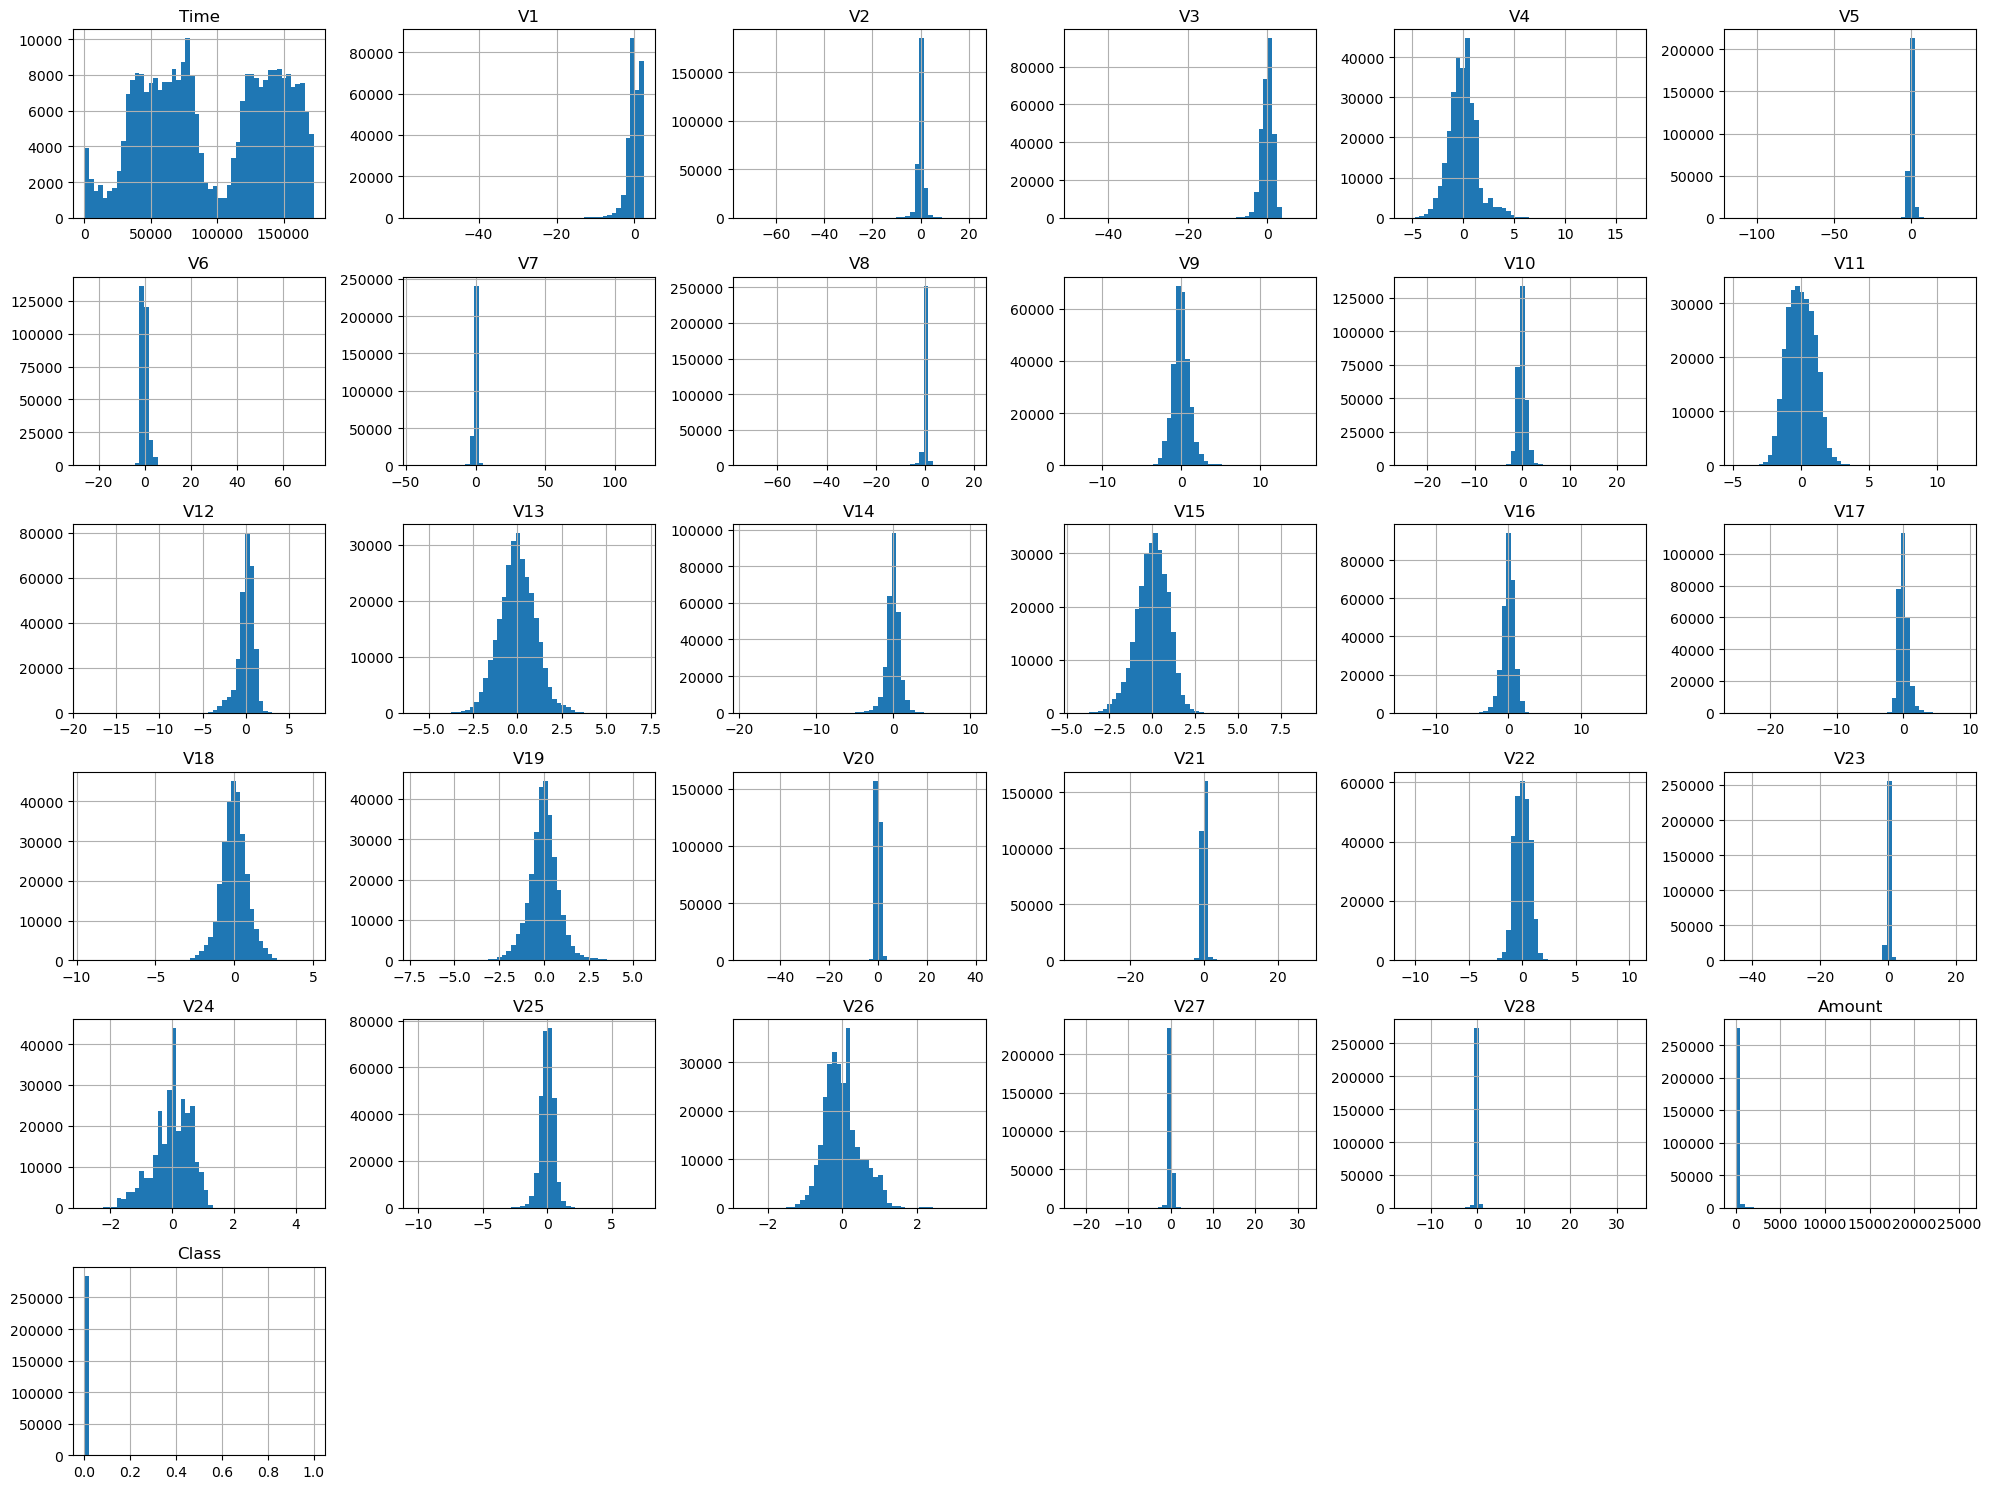

In [7]:
# Exploratory data analysis on all features' distribution
data.hist(bins=50, figsize=(20, 15))
plt.tight_layout()
plt.show()

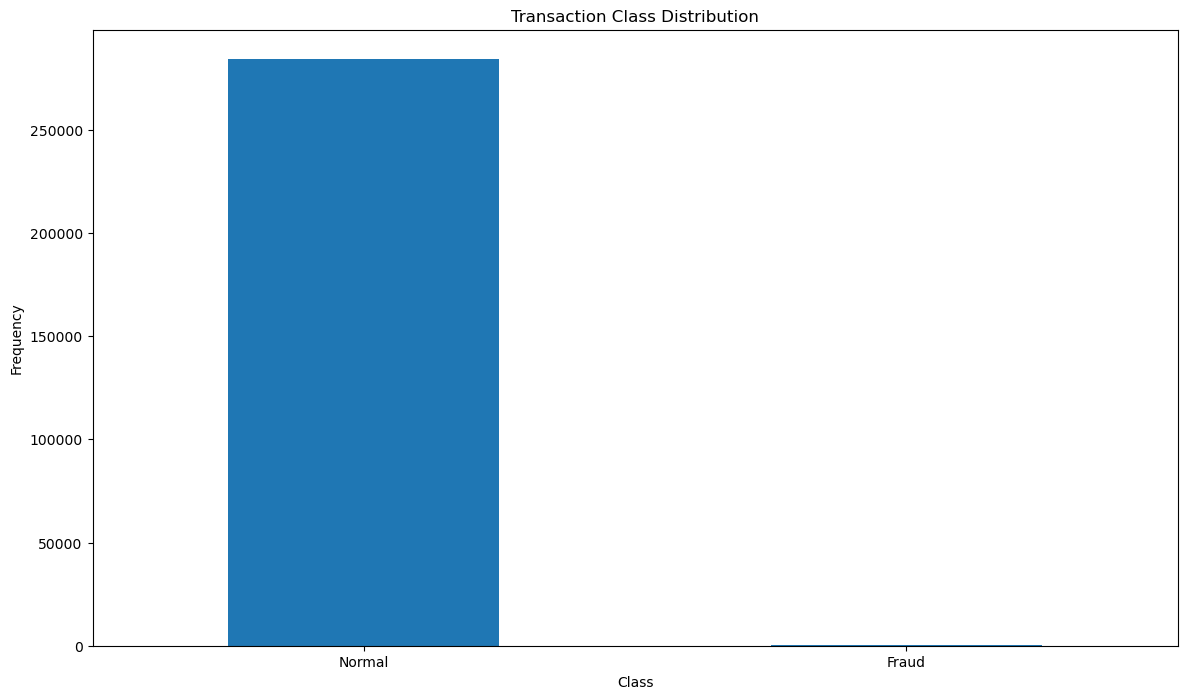

Total number of transactions: 284807
Transaction class distribution:
0    284315
1       492
Name: Class, dtype: int64
Transaction class percentage distribution:
0    99.827251
1     0.172749
Name: Class, dtype: float64


In [8]:
# Exploratory data analysis on the count of both classes of transactions. A plot for comparison
count_classes = pd.value_counts(data['Class'], sort = True)
count_classes.plot(kind = 'bar', rot=0)
plt.title("Transaction Class Distribution")
plt.xticks(range(2), LABELS)
plt.xlabel("Class")
plt.ylabel("Frequency")
plt.show()

# Print total number of transactions
total_transactions = len(data)
print(f"Total number of transactions: {total_transactions}")

# Print the count of each class
print("Transaction class distribution:")
print(count_classes)

# Calculate and print the percentage of each class
class_percentages = (count_classes / total_transactions) * 100
print("Transaction class percentage distribution:")
print(class_percentages)

In [9]:
# Separating the dataset into two subsets: the fraud dataset and the normal transactions dataset
fraud = data[data['Class']==1]
normal = data[data['Class']==0]
print(fraud.shape,normal.shape)       #shape on a dataframe returns a tuple of its dimensions (rows, columns)

(492, 31) (284315, 31)


In [10]:
# Comparison of the "Amount" feature in the two datasets, to understand the central tendency and spread in each
# Fraud:
fraud.Amount.describe()

count     492.000000
mean      122.211321
std       256.683288
min         0.000000
25%         1.000000
50%         9.250000
75%       105.890000
max      2125.870000
Name: Amount, dtype: float64

In [11]:
# Normal:
normal.Amount.describe()

count    284315.000000
mean         88.291022
std         250.105092
min           0.000000
25%           5.650000
50%          22.000000
75%          77.050000
max       25691.160000
Name: Amount, dtype: float64

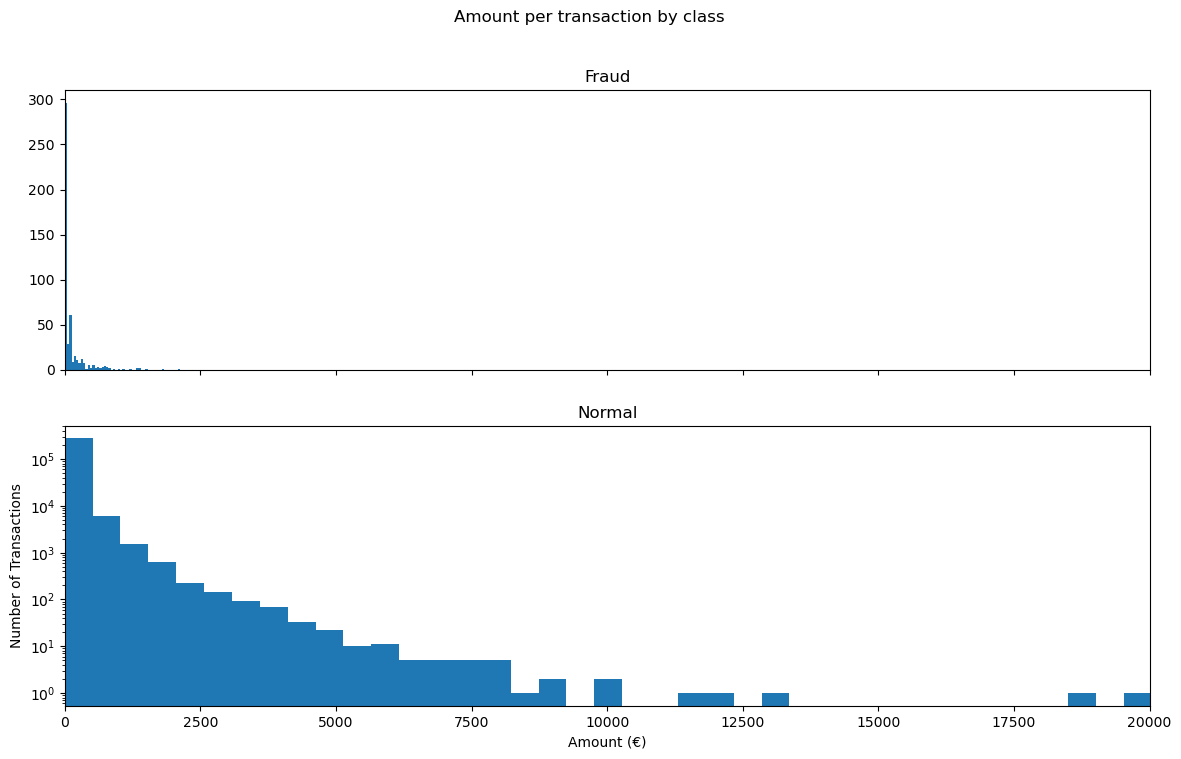

In [12]:
# Plot the transactions, to compare the distribution of amounts between fraudulent and normal
f, (ax1, ax2) = plt.subplots(2,1, sharex=True)
f.suptitle('Amount per transaction by class')
bins = 50
ax1.hist(fraud.Amount, bins = bins)
ax1.set_title('Fraud')
ax2.hist(normal.Amount, bins = bins)
ax2.set_title('Normal')
plt.xlabel('Amount (€)')
plt.ylabel('Number of Transactions')
plt.xlim((0, 20000))       #This ensures that extreme values do not skew the visualization
plt.yscale('log')          #Log scale helps to better visualize it when dealing with skewed data and a large difference in the number of transactions
plt.show();


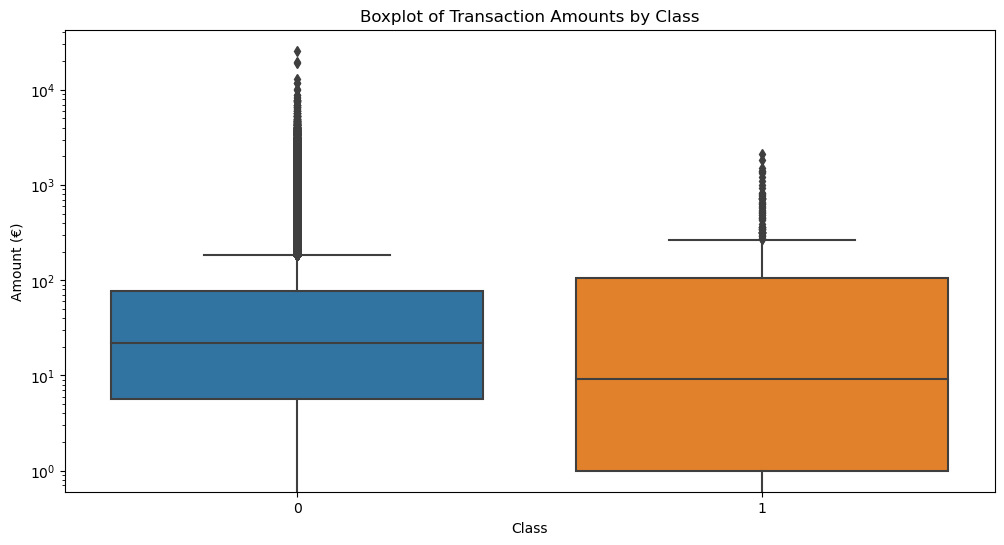

In [13]:
# Boxplots: To compare the distributions more comprehensively, boxplots highlight the median, quartiles, and potential outliers
plt.figure(figsize=(12, 6))
sns.boxplot(x='Class', y='Amount', data=data)
plt.yscale('log')
plt.title('Boxplot of Transaction Amounts by Class')
plt.xlabel('Class')
plt.ylabel('Amount (€)')
plt.show()

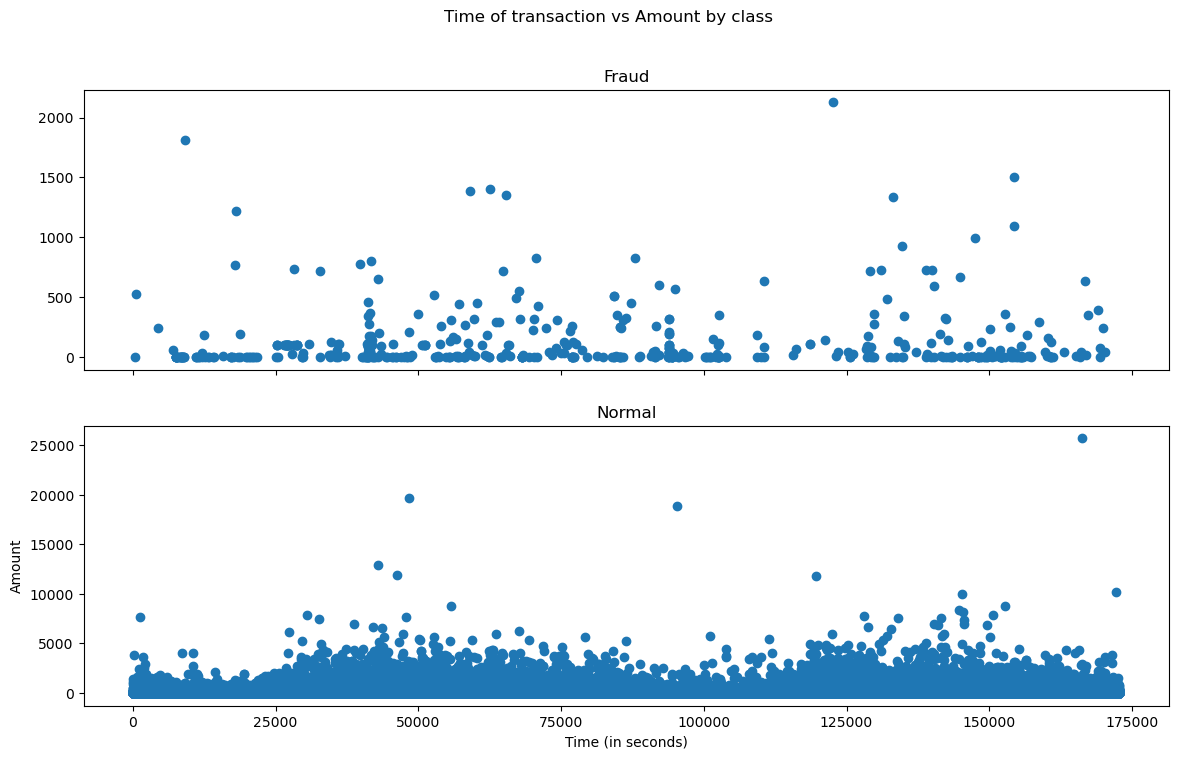

In [14]:
# Scatter plot to check if there are differences in occurrence for fraudulent transactions across time
f, (ax1,ax2) = plt.subplots(2, 1, sharex = True)
f.suptitle('Time of transaction vs Amount by class')
ax1.scatter(fraud.Time, fraud.Amount)
ax1.set_title('Fraud')
ax2.scatter(normal.Time, normal.Amount)
ax2.set_title('Normal')
plt.xlabel('Time (in seconds)')
plt.ylabel('Amount')
plt.show()

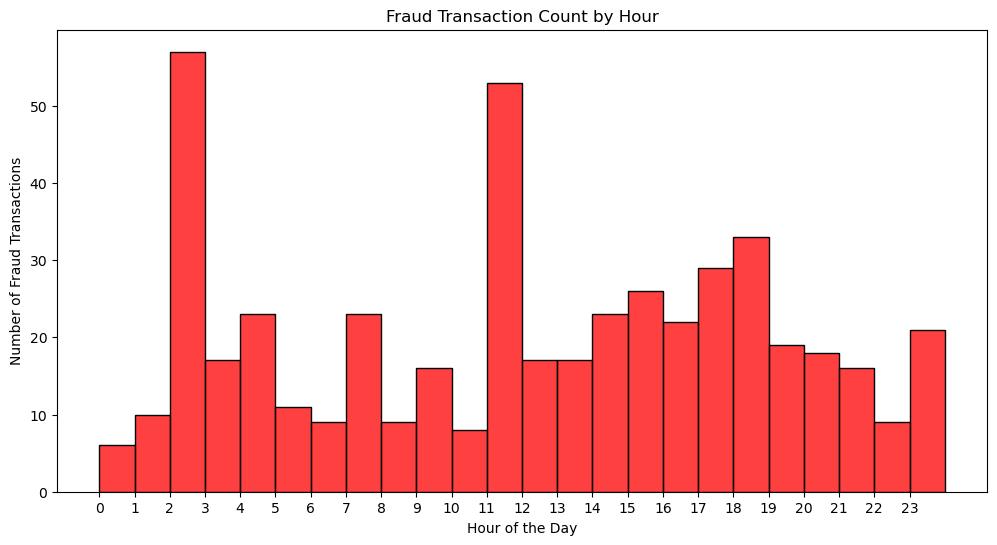

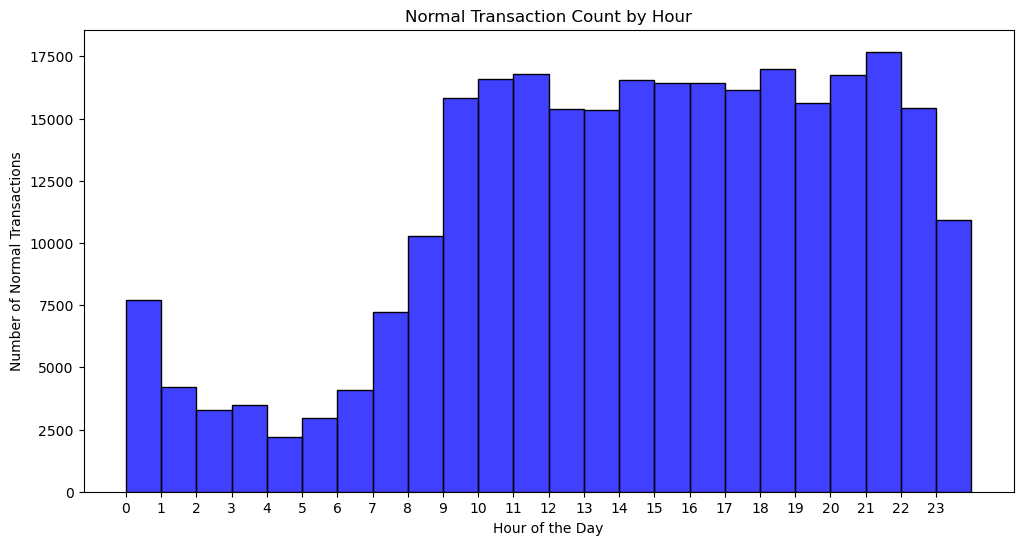

In [15]:
# Time-series analysis: Adding 'Hour' feature
data['Hour'] = (data['Time'] // 3600) % 24

# Separate Histograms for the 'Hour' feature
plt.figure(figsize=(12, 6))
sns.histplot(data[data['Class'] == 1]['Hour'], bins=24, kde=False, color='red', binrange=(0, 24))
plt.title('Fraud Transaction Count by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Fraud Transactions')
plt.xticks(range(24))    # Set x-ticks to show all hours
plt.show()

plt.figure(figsize=(12, 6))
sns.histplot(data[data['Class'] == 0]['Hour'], bins=24, kde=False, color='blue', binrange=(0, 24))
plt.title('Normal Transaction Count by Hour')
plt.xlabel('Hour of the Day')
plt.ylabel('Number of Normal Transactions')
plt.xticks(range(24))    # Set x-ticks to show all hours
plt.show()

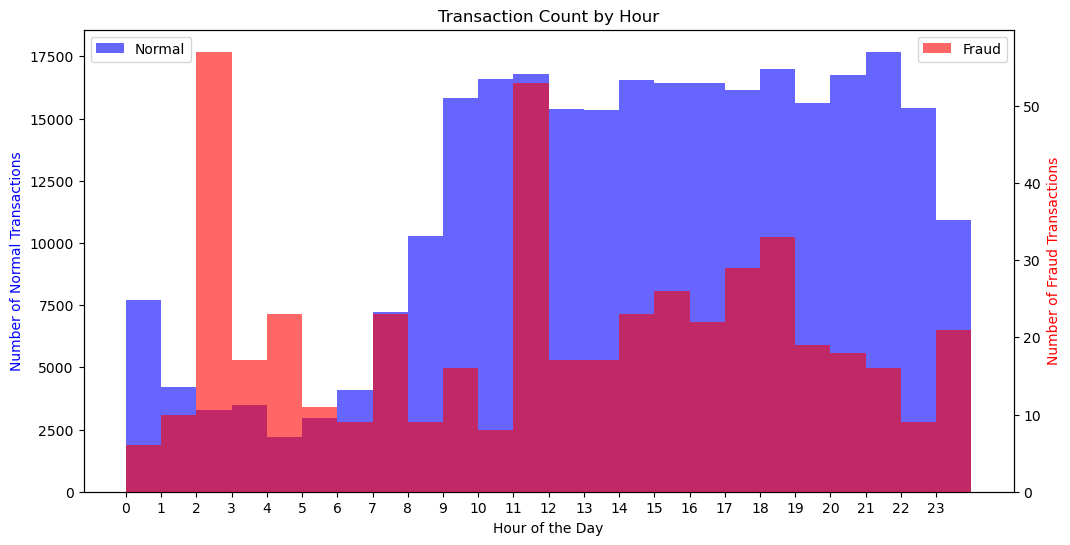

In [16]:
# Dual-Axis plot to better aprpeciate the differences in "Hour", overlaying both distributions
fig, ax1 = plt.subplots(figsize=(12, 6))

ax2 = ax1.twinx()
ax1.hist(data[data['Class'] == 0]['Hour'], bins=24, color='blue', alpha=0.6, label='Normal', range=(0, 24), align='mid')
ax2.hist(data[data['Class'] == 1]['Hour'], bins=24, color='red', alpha=0.6, label='Fraud', range=(0, 24), align='mid')

ax1.set_xlabel('Hour of the Day')
ax1.set_ylabel('Number of Normal Transactions', color='blue')
ax2.set_ylabel('Number of Fraud Transactions', color='red')
ax1.set_xticks(range(24))  # Set x-ticks to show all hours

ax1.set_title('Transaction Count by Hour')
ax1.legend(loc='upper left')
ax2.legend(loc='upper right')

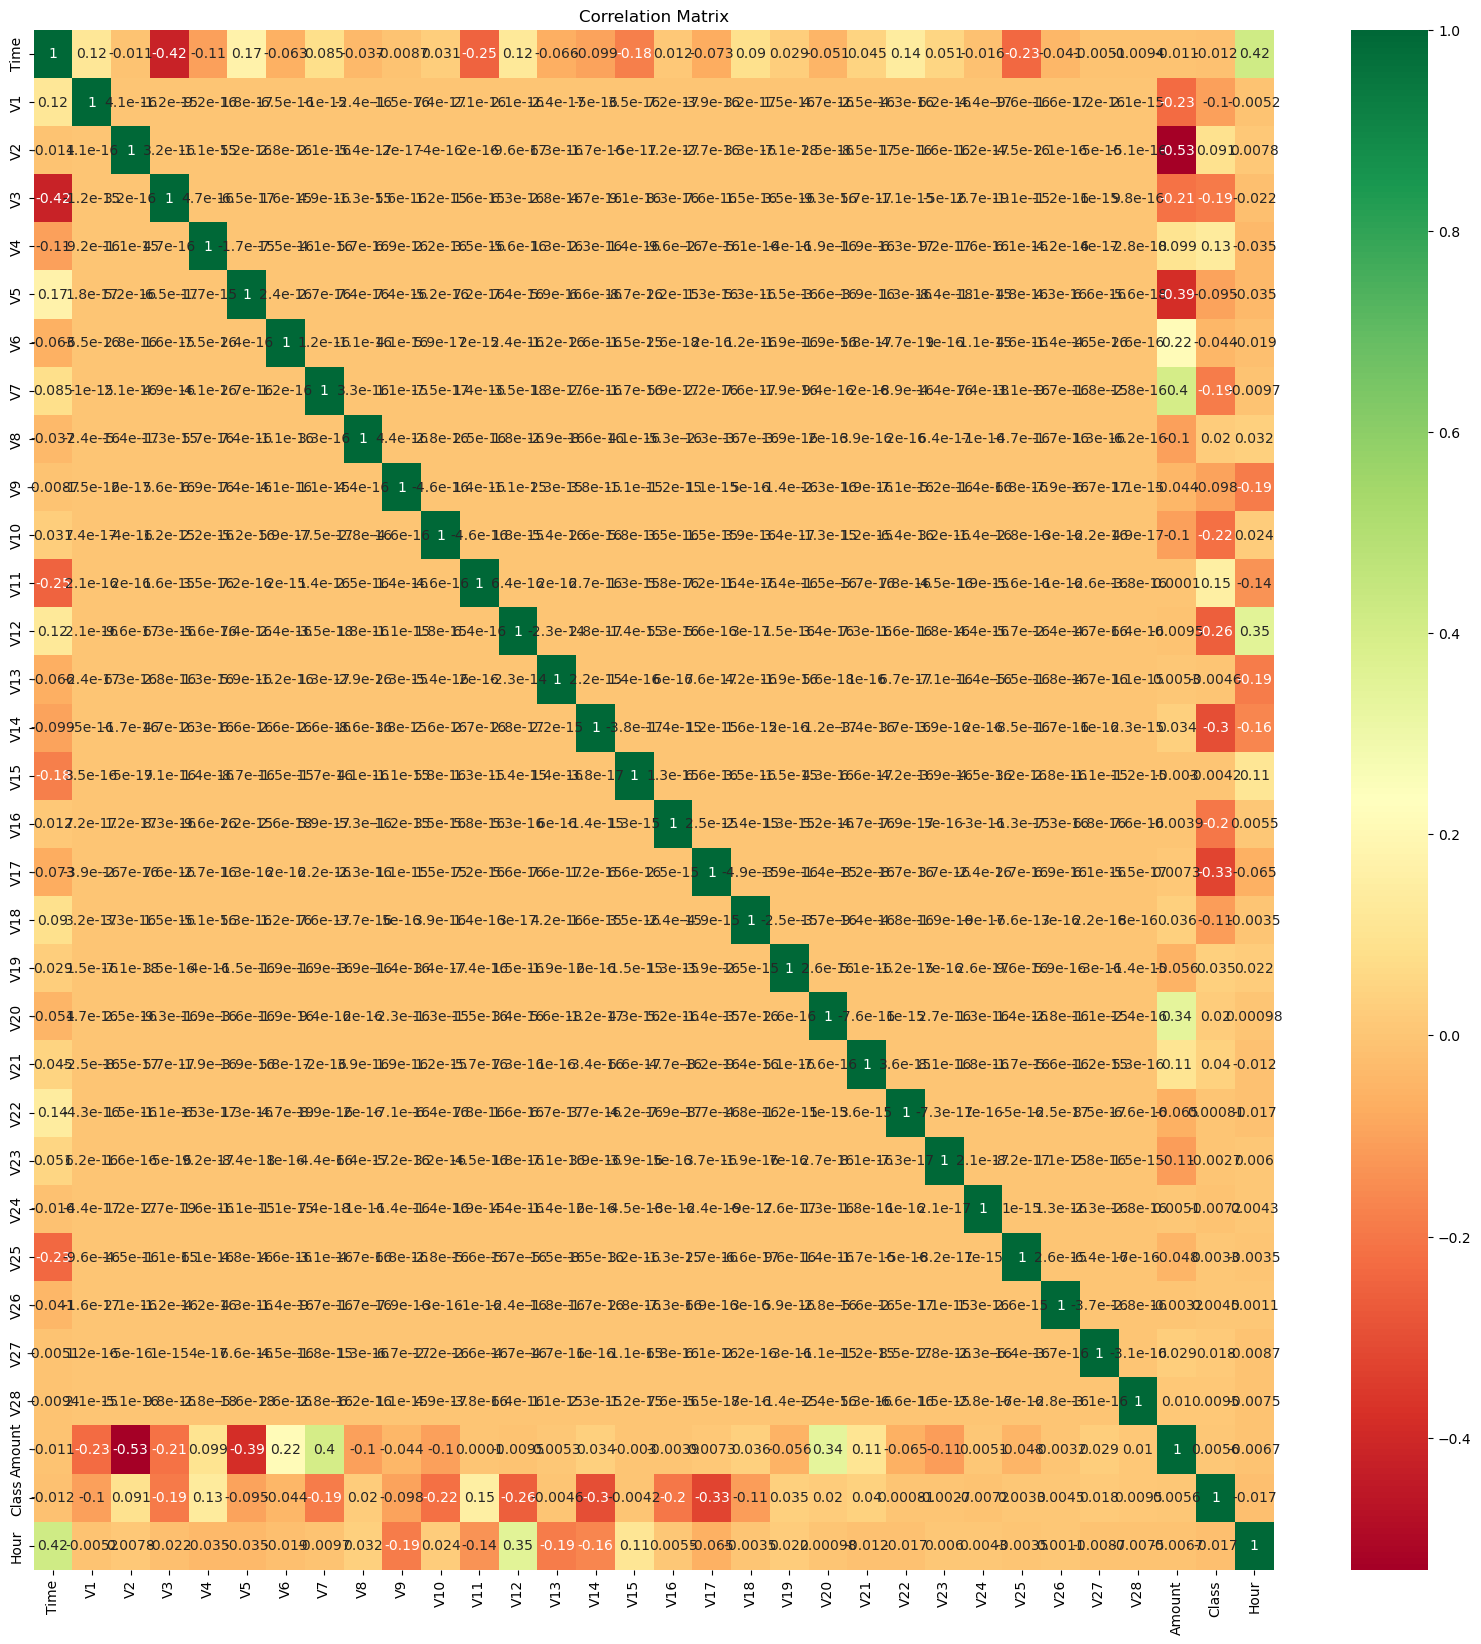

In [17]:
# Correlations Matrix. We analyze the relationships between features 
corrmat = data.corr()
plt.figure(figsize=(20, 20))
sns.heatmap(corrmat, annot=True, cmap="RdYlGn")   # we plot a heat map
plt.title("Correlation Matrix")
plt.show()